In [1]:
import numpy as np
import sys
sys.path.append('../')
import pickle
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from src.Mondrian_matrix_utils import simulate
import pandas as pd
import jax.numpy as jnp
from jax import grad, vmap

dim_in = 10
active = 1
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
#rotation = pickle.load(open("rotation.pk", "rb"))
rotation = special_ortho_group.rvs(dim_in)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [1000, 2000]

In [2]:
M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta


In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / 5000
true_H = true_H / two_one_norm(true_H)

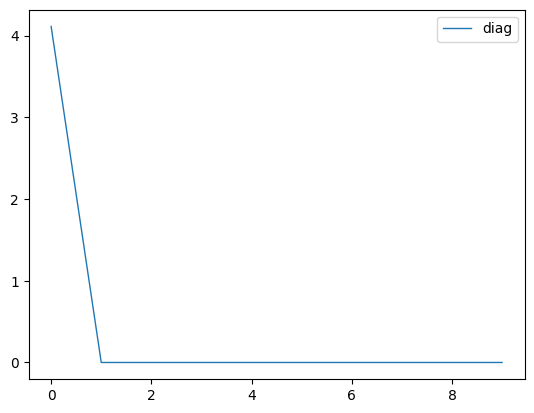

In [4]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [5]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    _, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

In [6]:
from src.Mondrian_matrix_utils import *
from sklearn.metrics import mean_squared_error
def train_and_evaluate(x_train, y_train, x_test, y_test, M, lifetime_max, delta):

    X_bd_all, X, history, w_kernel, y_hat_train = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                    weights_from_lifetime=weights_lifetime)
    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                    weights_from_lifetime=weights_lifetime)

    mse = mean_squared_error(y_test, y_hat_test)
    return mse, X_bd_all, X, history, w_kernel, y_hat_train

def estimate_H(x_train, y_train, X_bd_all, M, delta, X, history, w_kernel, y_hat_train):
    dim_in = X.shape[1]

    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_train[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, delta, history, w_kernel, mondrian_kernel = True, 
                                    weights_from_lifetime=weights_lifetime)
            y_eval = np.array(y_eval)
            x_diff = np.array(x_diff)
            importance_temp = populate_importance(subset_all, ((y_eval - y_hat_eval)/x_diff))
            importance_temp = np.reshape(importance_temp, (len(X), M))
            importance_temp = np.median(importance_temp, axis = 1)
        except:
            importance_temp = np.zeros(len(X))
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))
    
    #eig = np.linalg.eig(H)[0]
    #y_diag = np.diagonal(H)
    #plot_spectrum(eig, y_diag, 'spectrum')
    return H

def transform_data(H, x_train, x_test):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    return x_train_transformed, x_test_transformed

In [7]:
stats = {}
for n_sim in sample_range:
    stats[n_sim] = []
    print(f"number of training samples: {n_sim}")
    for index in range(5):
        results = {'full': [], 'partial': []}
        mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        x_train_transformed, x_test_transformed = transform_data(H_0, x_train[:n_sim, ], x_test)
        results['full'].append(mse)
        results['partial'].append(mse)
        print(f"mse before:{mse}")
        H = H_0
        print("full")
        for reiterate in range(10):
            #print(get_angle_distance(H, true_H))
            mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train_transformed, y_train[:n_sim], x_test_transformed, y_test, M, lifetime_max, delta)
            results['full'].append(mse)
            print(mse)
            H_itr = estimate_H(x_train_transformed, y_train[:n_sim], X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
            H = np.matmul(np.matmul(H, H_itr), H)
            H = H / two_one_norm(H)
            x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
        H = H_0
        print("partial")
        for reiterate in range(10):
            #print(get_angle_distance(H, true_H))
            mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train_transformed, y_train[:n_sim], x_test_transformed, y_test, M, lifetime_max, delta)
            results['partial'].append(mse)
            print(mse)
            H_itr = estimate_H(x_train_transformed, y_train[:n_sim], X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
            H = np.matmul(H, H_itr)
            H = H / two_one_norm(H)
            x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
        print("\n")
        stats[n_sim].append(results)

number of training samples: 1000
mse before:0.5025593638420105
full
0.48196787
0.4852005
0.49198514
0.49287412
0.49270478
0.49028575
0.49167958
0.49343488
0.49212655
0.49164385
partial
0.49207255
0.48185596
0.48333994
0.48804423
0.48875615
0.4898346
0.48939374
0.49193856
0.4904586
0.48937842


mse before:0.4993278384208679
full
0.47875297
0.47639814
0.4770016
0.477613
0.47806144
0.47683218
0.47975156
0.4779044
0.47744215
0.47957763
partial
0.47675985
0.466838
0.4692795
0.46291363
0.46263722
0.45879078
0.4594707
0.45350596
0.45205098
0.44736844


mse before:0.500598132610321
full
0.4768386
0.48222157
0.48231128
0.48356852
0.4838961
0.48266962
0.48242626
0.48098633
0.48103496
0.48351896
partial
0.483492
0.47794077
0.47714776
0.47982803
0.48378062
0.48150384
0.48456767
0.48460698
0.48388976
0.48220035


mse before:0.49958115816116333
full
0.48095405
0.48744932
0.48663795
0.4873385
0.4874221
0.48876777
0.48720983
0.4882423
0.48640054
0.48865604
partial
0.48899463
0.4870582
0.48562735
0.487

In [8]:
stats

{1000: [{'full': [0.50255936,
    0.48196787,
    0.4852005,
    0.49198514,
    0.49287412,
    0.49270478,
    0.49028575,
    0.49167958,
    0.49343488,
    0.49212655,
    0.49164385],
   'partial': [0.50255936,
    0.49207255,
    0.48185596,
    0.48333994,
    0.48804423,
    0.48875615,
    0.4898346,
    0.48939374,
    0.49193856,
    0.4904586,
    0.48937842]},
  {'full': [0.49932784,
    0.47875297,
    0.47639814,
    0.4770016,
    0.477613,
    0.47806144,
    0.47683218,
    0.47975156,
    0.4779044,
    0.47744215,
    0.47957763],
   'partial': [0.49932784,
    0.47675985,
    0.466838,
    0.4692795,
    0.46291363,
    0.46263722,
    0.45879078,
    0.4594707,
    0.45350596,
    0.45205098,
    0.44736844]},
  {'full': [0.50059813,
    0.4768386,
    0.48222157,
    0.48231128,
    0.48356852,
    0.4838961,
    0.48266962,
    0.48242626,
    0.48098633,
    0.48103496,
    0.48351896],
   'partial': [0.50059813,
    0.483492,
    0.47794077,
    0.47714776,
 

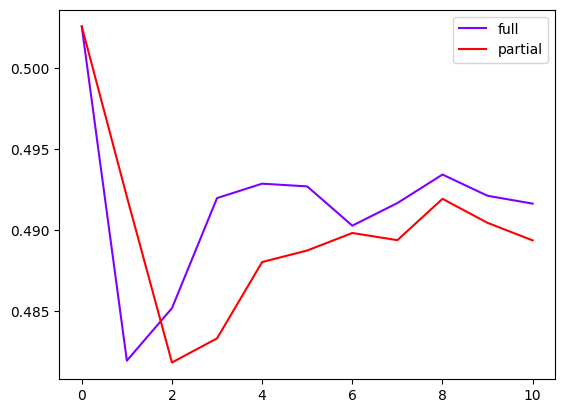

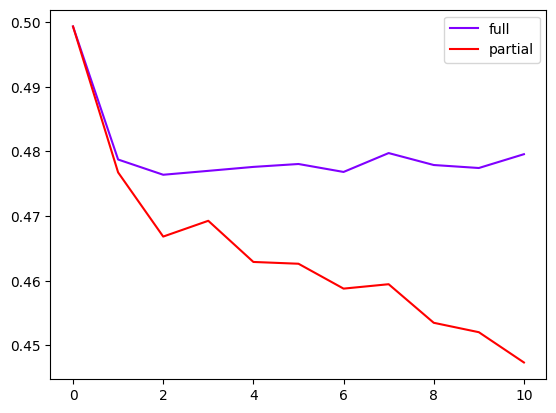

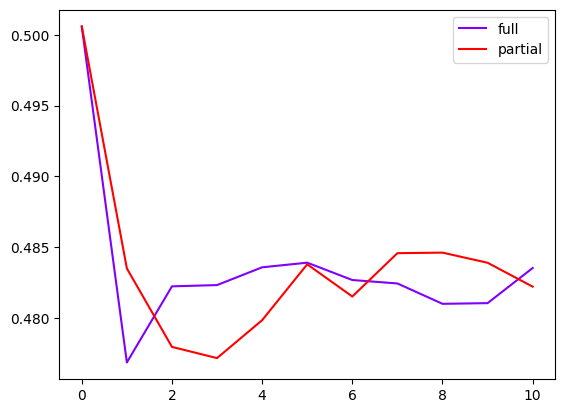

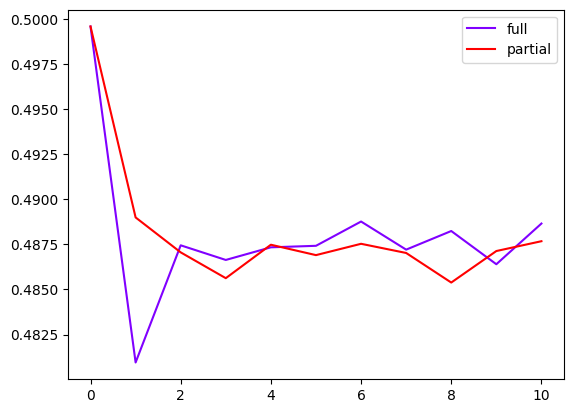

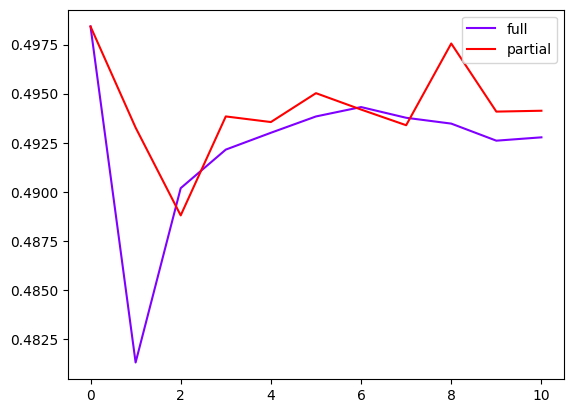

In [15]:
x = [0,1,2,3,4,5,6,7,8,9,10]

colors = plt.cm.rainbow(np.linspace(0, 1, 2))


for tries in range(5):
    fig, ax = plt.subplots()
    ax.plot(x, stats[1000][tries]['full'], color=colors[0])
    ax.plot(x, stats[1000][tries]['partial'], color=colors[1])
    plt.legend(["full", "partial"], loc ="upper right")

In [14]:
from src.Mondrian_matrix_utils import *

def simulate_proj_H(x_train, y_train, x_test, y_test, M, lifetime_max, delta, weights_lifetime, H = None):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    _, _, history, w_kernel, _ = train(x_train_transformed, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    _, y_hat_test = evaluate(x_test_transformed, y_train, x_test_transformed, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_best = mean_squared_error(y_test, y_hat_test)

    return mse_best

stats_best = {}
best = {}

for multiplier in range(1,2):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime, H = true_H)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))


lifetime multiplier: 1
number of training samples: 1000
Simulation: 0
0.36872342
Simulation: 1
0.3601456
Simulation: 2
0.36653262
Simulation: 3
0.3614925
Simulation: 4
0.35759208
number of training samples: 2000
Simulation: 0
0.35363144
Simulation: 1
0.35599878
Simulation: 2
0.35688826
Simulation: 3
0.35350722
Simulation: 4
0.3512016
